In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import copy

In [2]:
from algebra import *
from cube import *

In [3]:
#Definições
TOL = sys.float_info.epsilon

In [4]:
class Camera:
    def __init__(self,fov,w,h,near,far, eye,at,up):
        self.fov = fov
        self.w = w
        self.h = h
        self.near = near
        self.far = far
        self.a = 2*near*np.tan(fov*np.pi/360)
        self.b = self.a*w/h
        self.eye = eye
        self.ze = unitario(at-eye)
        self.xe = unitario(cross(self.ze,up))
        self.ye = cross(self.ze,self.xe)
        self.img = np.full((h,w,3),0,dtype=np.float64)
        self.zbuffer = np.full((h,w,3),np.inf,dtype=np.float64)
        
    def show(self):
        print("CAMERA")
        print(f'fov={self.fov}, n={self.near},f={self.far}')
        print(f'(w,h)=({self.w},{self.h})')
        print(f'(b,a)=({self.b},{self.a})')
        print(f'xe={self.xe}')
        print(f'ye={self.ye}')
        print(f'ze={self.ze}') 
    
    def LookAt(self):
        I = identidade()
        R = mudanca_de_base(I,self.xe,self.ye,self.ze)
        Lat = translada(R,-self.eye[0],-self.eye[1],-self.eye[2])
        return Lat
    
    def projection(self):
        P = identidade()
        P[1,1] = 1/np.tan(self.fov*np.pi/360)
        P[0,0] = P[1,1]*(self.h/self.w)
        P[2,2] = (self.far+self.near)/(self.far-self.near)
        P[2,3] = -2*self.far*self.near/(self.far-self.near)
        P[3,2] = 1
        P[3,3] = 0
        return P
    
    def to_canvas(self, xn,yn,zn):
        xc = int(round((self.w-1)*(xn + 1)/2))
        yc = int(round((self.h-1)*(yn + 1)/2))
        zc = int(round((65536 - 1)*(zn + 1)/2))
        
        return np.array([xc,yc,zc],dtype=int)
        
    def ray_to(self,x,y):
        dx = self.b*(x/self.w-0.5)
        dy = self.a*(y/self.h-0.5)
        dz = self.near
        ray = dx*self.xe+dy*self.ye+dz*self.ze
        return ray

    def get_eye(self):
        return self.eye

    def get_pixel(self,x,y):
        return self.img[y,x,:]

    def set_pixel(self,x,y,rgb):
        self.img[y,x,:]=rgb

    def add_pixel(self,x,y,rgb):
        self.img[y,x,:]+=rgb

    def get_w(self):
        return self.w

    def get_h(self):
        return self.h

    def imshow(self):
        img_max = np.amax(self.img)
        if img_max < TOL:
            print("Imagem Zerada")
        self.img = self.img/img_max
        plt.imshow(self.img)
        plt.show()
    

In [5]:
eye = vetor(1.5,1.5,1.2)
at = vetor(0,0,0)
up = vetor(0,0,1) 

camera = Camera(45,640,480,0.5,10,eye,at,up)
camera.show() 

CAMERA
fov=45, n=0.5,f=10
(w,h)=(640,480)
(b,a)=(0.5522847498307933,0.41421356237309503)
xe=[-0.70710678  0.70710678  0.        ]
ye=[ 0.34815531  0.34815531 -0.87038828]
ze=[-0.61545745 -0.61545745 -0.49236596]


In [6]:
class Material:
    def __init__(self, ambient, diffuse, specular, shiness):
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular
        self.shiness = shiness
        
    def show(self):
        print(f'{self.ambient} = ambient')
        print(f'{self.diffuse} = diffuse')
        print(f'{self.specular} = specular')
        print(f'{self.shiness} = shiness')
        
    def get_values(self):
        return self.ambient, self.diffuse, self.specular, self.shiness
    

In [7]:
brass= Material(vetor(0.33,0.22,0.03),vetor(0.78,0.57,0.11),vetor(0.99,0.91,0.81),27.8)

In [8]:
class ObjectBuffer:
    """
    Armazena um conjunto de primitivas necessárias para instanciar um objeto na cena
    
    Parameters:
        vertex (np.array): Conjunto de Verticies do Objeto (Coordenadas)
        triangles (np.array): Indices de cada Conjunto de verticies do triangulo
        normals (np.array): Conjunto de normais de cada vertice
        materiais (np.array): Materiais de cada triangulo
    Returns:
        ObjectBuffer: Instância do ObjectBuffer
    """
    def __init__(self, vertex, triangles, normals, material):
        self.vertex = copy.deepcopy(vertex)
        self.color = np.zeros(shape=vertex.shape,dtype= np.float64)
        self.triangles = copy.deepcopy(triangles)
        self.normals = copy.deepcopy(normals)
        self.material = copy.deepcopy(material)
        self.Mview = identidade()
    
    def ShowConfigurations(self, verbose = True):
        print("Coordernadas: ")
        for i in range(self.vertex.shape[0]):
            print(f"\t v{i} = {self.vertex[i,:]} n{i} = {self.normals[i, :]}")
        
        if(verbose):
            print("Triângulos: ")
            for i in range(self.triangles.shape[0]):
                print(f"\t t{i} = {self.triangles[i,:]}")
    
            print("Material")
            self.material.show()
    
    
    def transforma(self,M):
        self.mview = copy.deepcopy(M)
        for i, v in enumerate(self.vertex):
            vp = to_projetivo(v)
            up = np.dot(M,vp)
            uc = to_cartesiano(up)
            self.vertex[i,:]=uc
            
        Minvt = np.linalg.inv(M.T)
        for i,normal in enumerate(self.normals):
            nh = to_projetivo(normal)
            nh = np.dot(Minvt,nh)
            nc = vetor(nh[0],nh[1],nh[2])
            nc = unitario(nc)
            self.normals[i,:]=nc
    
    def projetar(self,P):
        self.projection = copy.deepcopy(P)
        
        for i in range(len(self.vertex)):
            vertex = self.vertex[i]
            vp = to_projetivo(vertex)
            up = np.dot(P, vp)
            uc = to_cartesiano(up)
            
            self.vertex[i,:]=uc
    
    
    def get_vertices(self):
        return self.vertex
    
    def get_normals(self):
        return self.normals
    
    def get_triangles(self):
        return self.triangles
    
    def get_material(self):
        return self.material
        


In [9]:
cubo = ObjectBuffer(vertices, indices, normals,brass)
cubo.ShowConfigurations()

Coordernadas: 
	 v0 = [-1. -1.  1.] n0 = [0. 0. 1.]
	 v1 = [ 1. -1.  1.] n1 = [0. 0. 1.]
	 v2 = [1. 1. 1.] n2 = [0. 0. 1.]
	 v3 = [-1.  1.  1.] n3 = [0. 0. 1.]
	 v4 = [-1. -1. -1.] n4 = [ 0.  0. -1.]
	 v5 = [-1.  1. -1.] n5 = [ 0.  0. -1.]
	 v6 = [ 1.  1. -1.] n6 = [ 0.  0. -1.]
	 v7 = [ 1. -1. -1.] n7 = [ 0.  0. -1.]
	 v8 = [-1.  1. -1.] n8 = [0. 1. 0.]
	 v9 = [-1.  1.  1.] n9 = [0. 1. 0.]
	 v10 = [1. 1. 1.] n10 = [0. 1. 0.]
	 v11 = [ 1.  1. -1.] n11 = [0. 1. 0.]
	 v12 = [-1. -1. -1.] n12 = [ 0. -1.  0.]
	 v13 = [ 1. -1. -1.] n13 = [ 0. -1.  0.]
	 v14 = [ 1. -1.  1.] n14 = [ 0. -1.  0.]
	 v15 = [-1. -1.  1.] n15 = [ 0. -1.  0.]
	 v16 = [ 1. -1. -1.] n16 = [1. 0. 0.]
	 v17 = [ 1.  1. -1.] n17 = [1. 0. 0.]
	 v18 = [1. 1. 1.] n18 = [1. 0. 0.]
	 v19 = [ 1. -1.  1.] n19 = [1. 0. 0.]
	 v20 = [-1. -1. -1.] n20 = [-1.  0.  0.]
	 v21 = [-1. -1.  1.] n21 = [-1.  0.  0.]
	 v22 = [-1.  1.  1.] n22 = [-1.  0.  0.]
	 v23 = [-1.  1. -1.] n23 = [-1.  0.  0.]
Triângulos: 
	 t0 = [0 1 2]
	 t1 = [0 2 3]

In [10]:
class Luz:
    def __init__(self,position,ambient,diffuse,specular):
        self.position = position
        self.ambient = ambient
        self.diffuse = diffuse
        self.specular = specular 
        
    def show(self):
        print("LUZ:")
        print(f'{self.position} = position')
        print(f'{self.ambient} = ambient')
        print(f'{self.diffuse} = diffuse')
        print(f'{self.specular} = specular')
        
    def get_pos(self):
        return self.position
    
    def get_values(self):
        return self.ambient,self.diffuse,self.specular

In [11]:
position = vetor(0.5,2,0)
low = vetor(0.2,0.2,0.2)
white = vetor(1,1,1)
luz = Luz(position,low,white,white)
luz.show()

LUZ:
[0.5 2.  0. ] = position
[0.2 0.2 0.2] = ambient
[1. 1. 1.] = diffuse
[1. 1. 1.] = specular


In [12]:
model = identidade()
model = escala(model,0.5,0.5,0.5)
cubo.transforma(model)
cubo.ShowConfigurations()

Coordernadas: 
	 v0 = [-0.5 -0.5  0.5] n0 = [0. 0. 1.]
	 v1 = [ 0.5 -0.5  0.5] n1 = [0. 0. 1.]
	 v2 = [0.5 0.5 0.5] n2 = [0. 0. 1.]
	 v3 = [-0.5  0.5  0.5] n3 = [0. 0. 1.]
	 v4 = [-0.5 -0.5 -0.5] n4 = [ 0.  0. -1.]
	 v5 = [-0.5  0.5 -0.5] n5 = [ 0.  0. -1.]
	 v6 = [ 0.5  0.5 -0.5] n6 = [ 0.  0. -1.]
	 v7 = [ 0.5 -0.5 -0.5] n7 = [ 0.  0. -1.]
	 v8 = [-0.5  0.5 -0.5] n8 = [0. 1. 0.]
	 v9 = [-0.5  0.5  0.5] n9 = [0. 1. 0.]
	 v10 = [0.5 0.5 0.5] n10 = [0. 1. 0.]
	 v11 = [ 0.5  0.5 -0.5] n11 = [0. 1. 0.]
	 v12 = [-0.5 -0.5 -0.5] n12 = [ 0. -1.  0.]
	 v13 = [ 0.5 -0.5 -0.5] n13 = [ 0. -1.  0.]
	 v14 = [ 0.5 -0.5  0.5] n14 = [ 0. -1.  0.]
	 v15 = [-0.5 -0.5  0.5] n15 = [ 0. -1.  0.]
	 v16 = [ 0.5 -0.5 -0.5] n16 = [1. 0. 0.]
	 v17 = [ 0.5  0.5 -0.5] n17 = [1. 0. 0.]
	 v18 = [0.5 0.5 0.5] n18 = [1. 0. 0.]
	 v19 = [ 0.5 -0.5  0.5] n19 = [1. 0. 0.]
	 v20 = [-0.5 -0.5 -0.5] n20 = [-1.  0.  0.]
	 v21 = [-0.5 -0.5  0.5] n21 = [-1.  0.  0.]
	 v22 = [-0.5  0.5  0.5] n22 = [-1.  0.  0.]
	 v23 = [-0.5  

In [13]:
vertices = cubo.get_vertices()
normals = cubo.get_normals()

eye = camera.get_eye()
pos_luz = luz.get_pos()
lamb, ldiff, lspec = luz.get_values()
mat = cubo.get_material()
ka,kd,ks,ns = mat.get_values()
for i,vertice in enumerate(vertices):
    normal = normals[i]
    veye = unitario(eye-vertice)
    vluz = unitario(pos_luz-vertice)
    rluz = reflete(vluz, normal)
    vcor = lamb*ka
    cosLN = np.dot(vluz, normal)
    if (cosLN>0):
        vcor += ldiff*kd*cosLN
        cosRE = np.dot(rluz, veye)
        if cosRE>0:
            vcor+= lspec*ks*(cosRE**ns)
    if(np.dot(normal,veye)>0):
        print(i,np.rint(255*vcor))

0 [17. 11.  2.]
1 [17. 11.  2.]
2 [17. 11.  2.]
3 [17. 11.  2.]
8 [176. 128.  24.]
9 [176. 128.  24.]
10 [206. 149.  28.]
11 [206. 149.  28.]
16 [17. 11.  2.]
17 [17. 11.  2.]
18 [17. 11.  2.]
19 [17. 11.  2.]


In [14]:
view = camera.LookAt()
cubo.transforma(view)
cubo.ShowConfigurations()

Coordernadas: 
	 v0 = [ 0.         -0.52223297  2.95419578] n0 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v1 = [-0.70710678 -0.17407766  2.33873833] n1 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v2 = [0.         0.17407766 1.72328087] n2 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v3 = [ 0.70710678 -0.17407766  2.33873833] n3 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v4 = [0.         0.34815531 3.44656175] n4 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v5 = [0.70710678 0.69631062 2.83110429] n5 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v6 = [0.         1.04446594 2.21564684] n6 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v7 = [-0.70710678  0.69631062  2.83110429] n7 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v8 = [0.70710678 0.69631062 2.83110429] n8 = [ 0.70710678  0.34815531 -0.61545745]
	 v9 = [ 0.70710678 -0.17407766  2.33873833] n9 = [ 0.70710678  0.34815531 -0.61545745]
	 v10 = [0.         0.17407766 1.723

In [15]:
vertices = cubo.get_vertices()
normals = cubo.get_normals()
pos_luz = luz.get_pos()
pos_luz = to_cartesiano(np.dot(view,to_projetivo(pos_luz)))
print(pos_luz)
lamb, ldiff, lspec = luz.get_values()
mat = cubo.get_material()
ka,kd,ks,ns = mat.get_values()
for i,vertice in enumerate(vertices):
    normal = normals[i]
    veye = unitario(-vertice)
    vluz = unitario(pos_luz-vertice)
    rluz = reflete(vluz, normal)
    vcor = lamb*ka
    cosLN = np.dot(vluz, normal)
    if (cosLN>0):
        vcor += ldiff*kd*cosLN
        cosRE = np.dot(rluz, veye)
        if cosRE>0:
            vcor+= lspec*ks*(cosRE**ns)
    if(np.dot(normal,veye)>0):
        print(i,np.rint(255*vcor))

[1.06066017 1.13150476 1.04627767]
0 [17. 11.  2.]
1 [17. 11.  2.]
2 [17. 11.  2.]
3 [17. 11.  2.]
8 [176. 128.  24.]
9 [176. 128.  24.]
10 [206. 149.  28.]
11 [206. 149.  28.]
16 [17. 11.  2.]
17 [17. 11.  2.]
18 [17. 11.  2.]
19 [17. 11.  2.]


In [16]:
P = camera.projection()
cubo.projetar(P)
cubo.ShowConfigurations()

Coordernadas: 
	 v0 = [ 0.         -0.4267767   0.74894568] n0 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v1 = [-0.54744478 -0.17969545  0.65517793] n1 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v2 = [0.        0.2438724 0.4944332] n2 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v3 = [ 0.54744478 -0.17969545  0.65517793] n3 = [-5.26588286e-17 -8.70388280e-01 -4.92365964e-01]
	 v4 = [0.         0.2438724  0.79984818] n4 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v5 = [0.45223699 0.59377627 0.73345362] n5 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v6 = [0.         1.13807119 0.63017319] n6 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v7 = [-0.45223699  0.59377627  0.73345362] n7 = [5.26588286e-17 8.70388280e-01 4.92365964e-01]
	 v8 = [0.45223699 0.59377627 0.73345362] n8 = [ 0.70710678  0.34815531 -0.61545745]
	 v9 = [ 0.54744478 -0.17969545  0.65517793] n9 = [ 0.70710678  0.34815531 -0.61545745]
	 v10 = [0.        0.2438724 0.4944332]

In [17]:
cube_vertex = cubo.get_vertices()
canvas_vertex = []
for i in range(cube_vertex.shape[0]):
    vertex = cube_vertex[i]
    vc = camera.to_canvas(vertex[0],vertex[1],vertex[2])
    canvas_vertex.append(vc)
    
    
canvas_vertex = np.array(canvas_vertex)

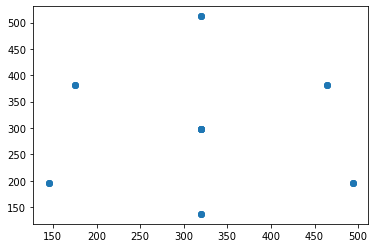

In [18]:
#example = plt.imread(canvasprint.jpg)
#plt.imgshow(example)
plt.scatter(canvas_vertex[:,0],canvas_vertex[:,1])
plt.show()

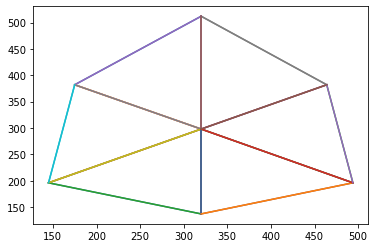

In [19]:
cube_triangles = cubo.get_triangles()

for triangle in cube_triangles:
    
    vertex1 = canvas_vertex[triangle[0]]
    vertex2 = canvas_vertex[triangle[1]]
    vertex3 = canvas_vertex[triangle[2]]
    
    plt.plot([vertex1[0],vertex2[0]], [vertex1[1],vertex2[1]])
    plt.plot([vertex2[0],vertex3[0]], [vertex2[1],vertex3[1]])
    plt.plot([vertex3[0],vertex1[0]], [vertex3[1],vertex1[1]])
                                        
    #plt.plot(vertex1[0],vertex1[1],vertex2[0],vertex2[1],linestyle='dotted')
    #plt.plot(vertex2[0],vertex2[1],vertex3[0],vertex3[1],linestyle='dotted')
    #plt.plot(vertex3[0],vertex3[1],vertex1[0],vertex1[1],linestyle='dotted')
                                        
                                        
    #plt.axline((vertex1[0],vertex1[1]),((vertex2[0],vertex2[1])))
    #plt.axline((vertex2[0],vertex2[1]),((vertex3[0],vertex3[1])))
    #plt.axline((vertex3[0],vertex3[1]),((vertex1[0],vertex1[1])))

#plt.imshow(example)
plt.show()